In [50]:
path = "COVID-Dialogue-Dataset-English.txt"
f = open(path,encoding="UTF-8")
l1 = f.read()
l2 = l1.split("id=")
p2d = []
d2p = []

def clean_sentence(str):
    str = str.replace(".", " . ").replace("\n", "").replace("/","")
    return str
for item in l2:
    if len(item) != 0:
        temp = item.split("Dialogue\nPatient:")
        if len(temp) > 1:
            item2 = temp[1]
            item3 = item2.split("Patient:")
            l = []
            if len(item3) != 0:
                for item4 in item3:
                    item5 = item4.split("Doctor:")
                    item5 = [clean_sentence(item6) for item6 in item5]
                    l += item5
            for i in range(1, len(l), 2):
                p2d.append((l[i - 1].strip("\n"), l[i].strip("\n")))
                if i + 1 < len(l):
                    d2p.append((l[i].strip("\n"), l[i + 1].strip("\n")))
data = p2d + d2p
data[0]

('Hello doctor, I get a cough for the last few days, which is heavy during night times .  No raise in temperature but feeling tired with no travel history .  No contact with any Covid-19 persons .  It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too .  Doctors have shut the OP so do not know what to do? Please help . ',
 'Hello, I understand your concern .  I just have a few more questions . Does your cough has phlegm? Any other symptoms like difficulty breathing? Any other medical condition such as asthma, hypertension? Are you a smoker? Alcoholic beverage drinker?')

In [51]:
import json
json_str = json.dumps(data)
f = open("dia_data.txt", "w")
json.dump(json_str,f)

In [52]:
for item in data:
    print(len(item[0]))

352
184
647
76
301
238
773
1496
428
1454
3579
1395
245
353
1557
158
35
24
25
19
47
37
45
26
35
47
156
84
262
160
146
82
82
211
218
249
142
82
197
257
149
137
149
307
268
265
329
391
302
747
534
398
358
302
834
865
1117
445
695
1378
573
359
621
300
295
1796
482
940
505
349
434
535
379
417
927
414
599
266
522
721
366
320
534
639
739
577
484
505
429
565
473
345
398
1082
763
284
525
632
298
431
540
401
335
506
278
300
269
477
323
704
532
291
499
388
308
269
962
461
334
360
2232
388
475
288
279
443
324
611
370
596
258
408
343
321
769
280
257
276
673
531
1056
532
266
266
580
368
314
342
397
349
313
474
419
276
517
277
953
273
272
275
328
498
331
321
624
290
414
413
1299
601
881
1669
606
322
263
360
492
299
319
355
322
544
939
713
521
414
483
142
115
88
257
248
256
132
238
164
75
252
253
138
231
28
19
138
143
148
160
243
68
255
232
142
261
82
216
227
215
174
256
138
142
228
224
159
229
258
131
254
242
37
248
249
162
104
217
247
204
253
66
126
204
191
159
218
239
237
239
237
126
99
58
255
237


In [53]:
import json
f = open("dialog_data.txt", "w")
json_str = json.dumps(data)
json.dump(json_str,f)

In [54]:
word_tokenize("Without any details it's impossible to say . ")

['Without', 'any', 'details', 'it', "'s", 'impossible', 'to', 'say', '.']

In [55]:
dictionary = {}

from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from itertools import chain

sw = stopwords.words('english')
punct = punctuation
reverse_flag = False
stopword_flag = False
words_min_times = 0
def clean_data(data):
    for item in data:
        for item2 in item:
            words = word_tokenize(item2)
            for word in words:
                dictionary.setdefault(word,0)
                dictionary[word] += 1
    data2 = []
    for item in data:
        temp = []
        flag = 0
        if "www" in item[0] or "www" in item[1]:
            continue
        for item2 in item:
            item2 = " ".join([token for token in word_tokenize(item2) if dictionary[token] > words_min_times])
            
            if reverse_flag and flag == 1:
                item2 = " ".join(reversed(item2.split(" ")))
            if stopword_flag:
                item2 = " ".join([token for token in word_tokenize(item2) if token.lower() not in chain(punct, sw)])
            temp.append(item2)
            flag += 1
        temp = tuple(temp)
        data2.append(temp)
    return data2
data2 = clean_data(data)
data2[0]

('Hello doctor , I get a cough for the last few days , which is heavy during night times . No raise in temperature but feeling tired with no travel history . No contact with any Covid-19 persons . It has been four to five days and has drunk a lot of Benadryl and took Paracetamol too . Doctors have shut the OP so do not know what to do ? Please help .',
 'Hello , I understand your concern . I just have a few more questions . Does your cough has phlegm ? Any other symptoms like difficulty breathing ? Any other medical condition such as asthma , hypertension ? Are you a smoker ? Alcoholic beverage drinker ?')

In [56]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [58]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"([.!?\'])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [59]:
def readLangs(lang):
    print("Reading lines...")
    '''
    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    '''
    pairs = [(normalizeString(item[0]), normalizeString(item[1])) for item in data2]
    # Reverse pairs, make Lang instances


    lang = Lang(lang)

    return lang, pairs

In [77]:
MAX_LENGTH = 50

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [78]:
def prepareData(lang):
    lang, pairs = readLangs(lang)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        #print(pair)
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, pairs


lang, pairs = prepareData('lang')
print(random.choice(pairs))

Reading lines...
Read 595 sentence pairs
Trimmed to 128 sentence pairs
Counting words...
Counted words:
lang 1395
('hi there . my 3 years old daughter had diarrhea for a couple of days and she has a fever without a cough now . can it be covid-19 ?', 'it could . only way to know is to test , self isolate : )')


In [79]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [80]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [81]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [82]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(lang, pair[0])
    target_tensor = tensorFromSentence(lang, pair[1])
    return (input_tensor, target_tensor)

In [83]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [84]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [85]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    print("the size of data is:", len(pairs))
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [86]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [87]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [88]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        p1 = pair[1].split(" ")
        if reverse_flag:
            p1 = reseverd(p1)
        print('=', " ".join(p1))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        if reverse_flag:
            output_words = reseverd(output_words)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

the size of data is: 128
0m 28s (- 23m 14s) (200 2%) 4.1077
0m 51s (- 20m 32s) (400 4%) 3.7411
1m 12s (- 18m 59s) (600 6%) 3.6332
1m 34s (- 18m 5s) (800 8%) 3.8403
2m 12s (- 19m 55s) (1000 10%) 3.6584
2m 40s (- 19m 34s) (1200 12%) 3.5161
3m 6s (- 19m 5s) (1400 14%) 3.1494
3m 33s (- 18m 39s) (1600 16%) 3.4000
4m 0s (- 18m 17s) (1800 18%) 3.1351
4m 28s (- 17m 54s) (2000 20%) 3.0773
4m 56s (- 17m 29s) (2200 22%) 2.6707
5m 21s (- 16m 58s) (2400 24%) 2.5154
5m 51s (- 16m 41s) (2600 26%) 2.5193
6m 25s (- 16m 31s) (2800 28%) 2.3908
6m 52s (- 16m 2s) (3000 30%) 2.1269
7m 25s (- 15m 46s) (3200 32%) 1.8447
7m 54s (- 15m 21s) (3400 34%) 1.5731
8m 24s (- 14m 56s) (3600 36%) 1.3443
8m 54s (- 14m 31s) (3800 38%) 1.0137
9m 29s (- 14m 14s) (4000 40%) 1.0968
9m 58s (- 13m 46s) (4200 42%) 0.9464
10m 28s (- 13m 19s) (4400 44%) 0.6162
10m 59s (- 12m 53s) (4600 46%) 0.5781
11m 30s (- 12m 27s) (4800 48%) 0.3631
12m 1s (- 12m 1s) (5000 50%) 0.4793
12m 32s (- 11m 34s) (5200 52%) 0.3578
13m 5s (- 11m 9s) (5400

<Figure size 432x288 with 0 Axes>

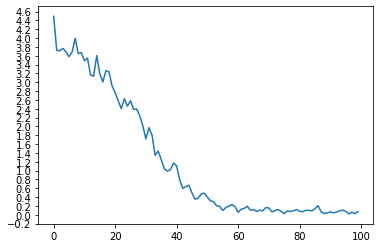

In [89]:
hidden_size = 256
encoder1 = EncoderRNN(lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 10000, print_every=200)

In [90]:
evaluateRandomly(encoder1, attn_decoder1)

> how do i book a virtual consultation with my doctor for covid-19 ?
= in brief : call your doctor call your doctor 's office for instructions would you like to video or text chat with me ?
< in brief : call your doctor call your doctor 's office for instructions would you like to video or text chat with me ? <EOS>

> how do i book a virtual consultation with my doctor for covid-19 ?
= in brief : call your doctor call your doctor 's office for instructions would you like to video or text chat with me ?
< in brief : call your doctor call your doctor 's office for instructions would you like to video or text chat with me ? <EOS>

> does getting covid19 make you immune to a reinfection or just less likely to be reinfected ?
= less likely nt immun . your body will develop antibodies against the virus but depending on how strong you keep your immune system , it is possible to get it again if you 're re-exposed with a weak immune system .
< less likely nt immun . your body will develop antib

In [91]:
pairs

antibacterial or normal handsoap ? is antibacterial better since it specialized to get rid germs better ? im confused since i read on internet , any kind of soap doesnt matter .',
  'in brief : any soap any soap should be effective against most viruses . antibacterial soap may advertise against bacterial but has no claim to be better against viruses . would you like to video or text chat with me ?'),
 ('experiencing pain and swelling accompanied by warmth to the touch with a red patch around my elbow . also experiencing body aches . what could be the problem ?',
  'might need treatment . could be infection or other condition requiring urgent treatment . seek evaluation , but preferably on phone or online , to avoid coronavirus exposure . video consultations are available on healthtap ; click on `` talk-to-doctor . `` .'),
 ('i use athraway chronic for rheumatoid arthritis , will this complicate things relating to the corona virus ?',
  'no . i do not think it will have any effect on co

In [92]:
lang.index2word

{0: 'SOS',
 1: 'EOS',
 2: 'thank',
 3: 'you',
 4: 'doctor',
 5: ',',
 6: 'after',
 7: 'doing',
 8: 'all',
 9: 'these',
 10: 'i',
 11: 'can',
 12: 'upload',
 13: 'for',
 14: 'further',
 15: 'query',
 16: '.',
 17: 'hi',
 18: 'yes',
 19: 'in',
 20: 'this',
 21: 'only',
 22: 'will',
 23: 'see',
 24: 'and',
 25: 'revert',
 26: 'to',
 27: 'have',
 28: 'covid',
 29: '19',
 30: 'symptoms',
 31: '?',
 32: 'without',
 33: 'any',
 34: 'details',
 35: 'it',
 36: "'s",
 37: 'impossible',
 38: 'say',
 39: 'do',
 40: 'is',
 41: 'vomiting',
 42: 'diarrhea',
 43: 'a',
 44: 'symptom',
 45: 'of',
 46: 'covid-19',
 47: 'nausea',
 48: 'andor',
 49: 'occur',
 50: 'fairly',
 51: 'frequently',
 52: 'early',
 53: 'the',
 54: 'infection',
 55: 'but',
 56: 'are',
 57: 'rarely',
 58: 'if',
 59: 'ever',
 60: 'cough',
 61: 'fever',
 62: "n't",
 63: 'develop',
 64: 'within',
 65: 'day',
 66: 'or',
 67: 'two',
 68: 'probably',
 69: 'coronavirus',
 70: '229e',
 71: 'same',
 72: 'as',
 73: 'cov229e',
 74: 'one',
 75: 

In [24]:
lang.n_words

5391

In [27]:
pairs

[('thank you doctor , after doing all these i can upload all for further query .',
  '. you to revert and see will i . only query this in upload , yes , hi'),
 ('i have covid 19 symptoms ?',
  ". say to impossible 's it details any without"),
 ('do i have covid 19 ?', ". say to impossible 's it details any without"),
 ('is the coronavirus 229e the same as covid-19 ?',
  '. viruses different but , ) covid-19 of cause the ( sars-cov-2 to related biologically . colds common cause that coronaviruses several of one is cov229e'),
 ('where can i be tested for covid 19 ?',
  '. live you where is up set your what here idea no have we , department health local , doctor local your'),
 ('am i at risk for covid-19 in the united states ?',
  '. measures prophylactic important most the probably are recommendations washing hand following and travel avoiding . us in weeks few next the over up pick likely will infections covid'),
 ('should i shave my beard to reduce my chances of contracting coronavirus